# Autoencoder
A type of neural network used to learn efficient data codings in an unsupervised manner. The aim is to learn a lower representation of a set of data which is useful for feature extraction, dimensionality reduction, and image denoising tasks.

Its architecture consists of an encoder, which compresses the input inot a latent space representation, also known as bottleneck, and a decoder, which reconstructs the input from the latent space representation.
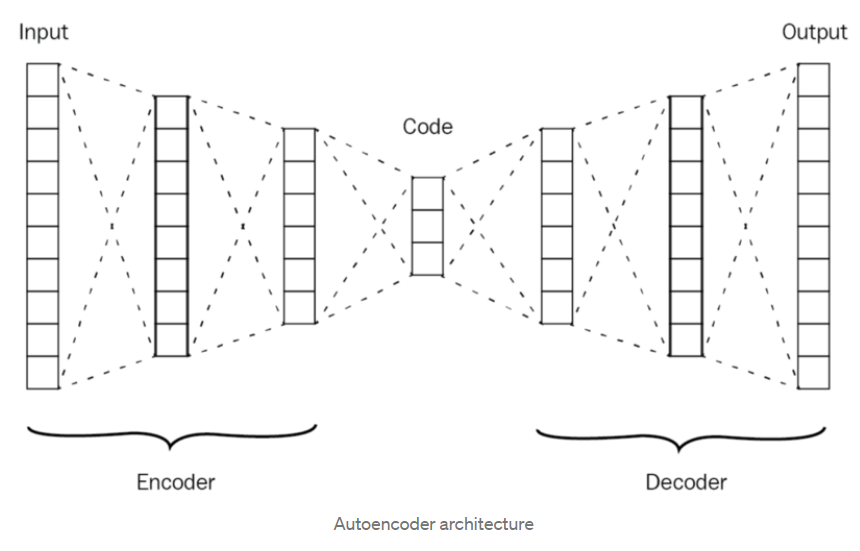

In [1]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
import struct
import time
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ExponentialLR

C:\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the Fashion MNIST Dataset

In [10]:
def read_idx(filename):
    with gzip.open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)

In [11]:
train_x = read_idx("./data/FashionMNIST/raw/train-images-idx3-ubyte.gz")
test_x = read_idx("./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz")
train_x = train_x[:5000]
test_x = test_x[:100]

C:\Users\USER\AppData\Local\Temp\ipykernel_17500\2859420377.py:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)


In [12]:
# Check the shape
print(f"train_x: {train_x.shape}")
print(f"test_x: {test_x.shape}")

train_x: (5000, 28, 28)
test_x: (100, 28, 28)


In [13]:
# Normalize the data
train_x = train_x/255
test_x = test_x/255

Reshape the arrays with the shape that PyTorch requires for the convolutional layers (train_x: (5000, 1, 28, 28), and test_x: (100, 1, 28, 28)), divide the train_x array into train and validation sets and load the three sets into PyTorch Dataloaders.

In [16]:
# Reshape the data
input_shape = (1,28,28)

x_train = train_x.reshape(train_x.shape[0], *input_shape)
x_test = test_x.reshape(test_x.shape[0], *input_shape)

x_train = torch.stack([torch.from_numpy(np.array(i)) for i in x_train])
x_test = torch.stack([torch.from_numpy(np.array(i)) for i in x_test])

train_set = torch.utils.data.TensorDataset(x_train, x_train)
train_set, val_set = torch.utils.data.random_split(train_set, [round(len(train_set) * .8), 
                                                               round(len(train_set) * .2)])
test_set = torch.utils.data.TensorDataset(x_test, x_test)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128)

## Build the neural network architecture

In [17]:
class Encoder(nn.Module):
    """
    Class for encoder part
    """
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=(3,3))
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3,3))
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3,3))
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3,3))
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        return x

In [18]:
class Decoder(nn.Module):
    """
    Class for decoder part
    """
    def __init__(self):
        super(Decoder, self).__init__()
        self.conv1 = nn.ConvTranspose2d(64, 32, kernel_size=(3,3))
        self.conv2 = nn.ConvTranspose2d(32, 16, kernel_size=(3,3))
        self.conv3 = nn.ConvTranspose2d(16, 8, kernel_size=(3,3))
        self.conv4 = nn.ConvTranspose2d(8, 1, kernel_size=(3,3))
        self.sigmoid_activation = torch.nn.Sigmoid()

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        x = self.sigmoid_activation(x)
        return x

In [19]:
class Autoencoder(torch.nn.Module):
    """
    Class for Autoencoder
    """
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Training the neural network

In [28]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [31]:
DEVICE

'cuda'

In [36]:
model = Autoencoder().to(DEVICE)

model_name = f"ae_{time.time()}"
print(model_name)

# Tensorboard
tb_writer = SummaryWriter('logs/'+model_name)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
scheduler = ExponentialLR(optimizer, gamma=0.999)

# Loss function
loss_func = torch.nn.MSELoss()

ae_1667808235.2600982


In [37]:
# Train the neural network
for epoch in range(500):
    # print(f'Epoch: {epoch}')
    current_time = time.time()

    # Train
    model.train()
    loss_tr = []
    for step, (images_raw, images_out) in enumerate(train_loader):
        images_raw, images_out = images_raw.to(device=DEVICE), images_out.to(device=DEVICE)
        p = model(images_raw.float())
        batch_loss = loss_func(images_out.float(), p)
        loss_tr.append(batch_loss.detach().item())
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
    print(f"{epoch}, training_loss {np.mean(loss_tr)}, {time.time() - current_time} secs")
    current_time = time.time()
    
    # Validation
    model.eval()
    loss_ts = []
    for step, (images_raw, images_out) in enumerate(val_loader):
        images_raw, images_out = images_raw.to(device=DEVICE), images_out.to(device=DEVICE)
        p = model(images_raw.float())
        batch_loss = loss_func(images_out.float(), p)       
        loss_ts.append(batch_loss.detach().cpu().numpy())
    print(f"{epoch}, validation_loss {np.mean(loss_ts)}, {time.time() - current_time} secs")
    scheduler.step()
    
    tb_writer.add_scalar("Test Loss", np.mean(loss_ts), epoch)
    tb_writer.add_scalar("Training Loss", np.mean(loss_tr), epoch)
    tb_writer.add_scalar("Learning Rate", scheduler.get_lr()[0], epoch)
    img_grid = torchvision.utils.make_grid(images_out[:4])
    tb_writer.add_image('orig_fashion_mnist_images', img_grid)
    img_grid = torchvision.utils.make_grid(p[:4])
    tb_writer.add_image('recons_fashion_mnist_images', img_grid)
    tb_writer.flush()

0, training_loss 0.1742540649138391, 0.29599452018737793 secs
0, validation_loss 0.15949779748916626, 0.04164266586303711 secs


C:\Python310\lib\site-packages\torch\optim\lr_scheduler.py:574: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


1, training_loss 0.15265263663604856, 0.30500316619873047 secs
1, validation_loss 0.1425851285457611, 0.031003475189208984 secs
2, training_loss 0.11327189835719764, 0.28000569343566895 secs
2, validation_loss 0.09497910737991333, 0.03099799156188965 secs
3, training_loss 0.0868436275050044, 0.2859950065612793 secs
3, validation_loss 0.07941746711730957, 0.03200125694274902 secs
4, training_loss 0.0751842288300395, 0.2992682456970215 secs
4, validation_loss 0.07088930904865265, 0.03502511978149414 secs
5, training_loss 0.0633778841001913, 0.28699588775634766 secs
5, validation_loss 0.05613618344068527, 0.031003475189208984 secs
6, training_loss 0.0510347451781854, 0.2804877758026123 secs
6, validation_loss 0.04501290246844292, 0.03199958801269531 secs
7, training_loss 0.043005619081668556, 0.2820017337799072 secs
7, validation_loss 0.041832320392131805, 0.03200030326843262 secs
8, training_loss 0.039649659185670316, 0.28060293197631836 secs
8, validation_loss 0.037698522210121155, 0.03

64, training_loss 0.018022256204858422, 0.29488658905029297 secs
64, validation_loss 0.017490457743406296, 0.03399920463562012 secs
65, training_loss 0.017096649447921664, 0.2999532222747803 secs
65, validation_loss 0.017017396166920662, 0.03100419044494629 secs
66, training_loss 0.017138640861958265, 0.2870004177093506 secs
66, validation_loss 0.017059486359357834, 0.032000064849853516 secs
67, training_loss 0.017124019708717242, 0.30600571632385254 secs
67, validation_loss 0.017083626240491867, 0.03400564193725586 secs
68, training_loss 0.016980250511551276, 0.3069956302642822 secs
68, validation_loss 0.01735554449260235, 0.033003807067871094 secs
69, training_loss 0.02117270790040493, 0.28600096702575684 secs
69, validation_loss 0.018184345215559006, 0.03499937057495117 secs
70, training_loss 0.01723025704268366, 0.2969992160797119 secs
70, validation_loss 0.016806671395897865, 0.033013343811035156 secs
71, training_loss 0.016526966588571668, 0.2969977855682373 secs
71, validation_l

127, training_loss 0.009451287827687338, 0.28800058364868164 secs
127, validation_loss 0.01029936969280243, 0.031999826431274414 secs
128, training_loss 0.010561493952991441, 0.2820007801055908 secs
128, validation_loss 0.009633798152208328, 0.031999826431274414 secs
129, training_loss 0.00935095114982687, 0.28299903869628906 secs
129, validation_loss 0.009331931360065937, 0.03200030326843262 secs
130, training_loss 0.009193576610414311, 0.283017635345459 secs
130, validation_loss 0.0096129160374403, 0.030999422073364258 secs
131, training_loss 0.010332938749343157, 0.28400087356567383 secs
131, validation_loss 0.00975187961012125, 0.03199958801269531 secs
132, training_loss 0.00927971547935158, 0.2830009460449219 secs
132, validation_loss 0.00917428731918335, 0.03299999237060547 secs
133, training_loss 0.008962125866673887, 0.28400087356567383 secs
133, validation_loss 0.008974313735961914, 0.031999826431274414 secs
134, training_loss 0.008874334627762437, 0.2850003242492676 secs
134,

189, training_loss 0.006532172643346712, 0.28394389152526855 secs
189, validation_loss 0.006890635937452316, 0.03299975395202637 secs
190, training_loss 0.006523701100377366, 0.2840147018432617 secs
190, validation_loss 0.006571188569068909, 0.032004356384277344 secs
191, training_loss 0.006418267948902212, 0.285001277923584 secs
191, validation_loss 0.007478978484869003, 0.0330052375793457 secs
192, training_loss 0.0065072807046817616, 0.2870035171508789 secs
192, validation_loss 0.006470862776041031, 0.03300046920776367 secs
193, training_loss 0.0064333796908613294, 0.2850017547607422 secs
193, validation_loss 0.0065392907708883286, 0.03299903869628906 secs
194, training_loss 0.006449050546507351, 0.28600192070007324 secs
194, validation_loss 0.006581122986972332, 0.032999515533447266 secs
195, training_loss 0.0070579034654656425, 0.2839956283569336 secs
195, validation_loss 0.007072447799146175, 0.0319976806640625 secs
196, training_loss 0.006439797653001733, 0.28400087356567383 sec

251, training_loss 0.005225105443969369, 0.2917029857635498 secs
251, validation_loss 0.005202202126383781, 0.03599977493286133 secs
252, training_loss 0.005187506263609976, 0.2908318042755127 secs
252, validation_loss 0.006335776299238205, 0.03299975395202637 secs
253, training_loss 0.005224138993071392, 0.2850024700164795 secs
253, validation_loss 0.005416742525994778, 0.03200364112854004 secs
254, training_loss 0.005141072761034593, 0.28400087356567383 secs
254, validation_loss 0.005108502693474293, 0.03199887275695801 secs
255, training_loss 0.005097440807730891, 0.2850170135498047 secs
255, validation_loss 0.00527556287124753, 0.032000064849853516 secs
256, training_loss 0.005166601520613767, 0.2850024700164795 secs
256, validation_loss 0.005117247812449932, 0.03200078010559082 secs
257, training_loss 0.005082418429083191, 0.2840006351470947 secs
257, validation_loss 0.005260754842311144, 0.032999515533447266 secs
258, training_loss 0.0051567053742473945, 0.2858147621154785 secs
2

313, training_loss 0.004371690767584369, 0.2930009365081787 secs
313, validation_loss 0.004568416625261307, 0.03200578689575195 secs
314, training_loss 0.004435294511495158, 0.2910008430480957 secs
314, validation_loss 0.00488071795552969, 0.03300023078918457 secs
315, training_loss 0.004377750301500782, 0.28800082206726074 secs
315, validation_loss 0.004380933940410614, 0.03199934959411621 secs
316, training_loss 0.004487138794502243, 0.2899942398071289 secs
316, validation_loss 0.004532120190560818, 0.031999826431274414 secs
317, training_loss 0.004902965360088274, 0.28800129890441895 secs
317, validation_loss 0.004751814063638449, 0.03399944305419922 secs
318, training_loss 0.004410782887134701, 0.2957940101623535 secs
318, validation_loss 0.00439814105629921, 0.03400468826293945 secs
319, training_loss 0.004285605289624073, 0.2969996929168701 secs
319, validation_loss 0.0044118077494204044, 0.0370020866394043 secs
320, training_loss 0.004313535799155943, 0.30100035667419434 secs
32

375, training_loss 0.003787351983191911, 0.2910025119781494 secs
375, validation_loss 0.004066636320203543, 0.03399920463562012 secs
376, training_loss 0.003837088879663497, 0.2910010814666748 secs
376, validation_loss 0.003910834435373545, 0.03399920463562012 secs
377, training_loss 0.003921833093045279, 0.28986382484436035 secs
377, validation_loss 0.003973442129790783, 0.033003807067871094 secs
378, training_loss 0.0038351935509126633, 0.2919960021972656 secs
378, validation_loss 0.003818061202764511, 0.033003807067871094 secs
379, training_loss 0.003784812448429875, 0.2890007495880127 secs
379, validation_loss 0.003923946991562843, 0.03199887275695801 secs
380, training_loss 0.0038571962795685977, 0.28800058364868164 secs
380, validation_loss 0.0038202761206775904, 0.03200197219848633 secs
381, training_loss 0.0038623816362814978, 0.29200243949890137 secs
381, validation_loss 0.00409554922953248, 0.03300333023071289 secs
382, training_loss 0.003776573794311844, 0.28999972343444824 

436, training_loss 0.0034248811352881603, 0.29400110244750977 secs
436, validation_loss 0.0034535815939307213, 0.034999847412109375 secs
437, training_loss 0.0034275148937013, 0.2960026264190674 secs
437, validation_loss 0.0036060097627341747, 0.032009124755859375 secs
438, training_loss 0.003433472433243878, 0.289886474609375 secs
438, validation_loss 0.0035029673017561436, 0.032000064849853516 secs
439, training_loss 0.003496606514090672, 0.2960035800933838 secs
439, validation_loss 0.00400034012272954, 0.03299975395202637 secs
440, training_loss 0.0035011836152989417, 0.29900145530700684 secs
440, validation_loss 0.003618899267166853, 0.03300023078918457 secs
441, training_loss 0.0034359505589236505, 0.2927868366241455 secs
441, validation_loss 0.0034809205681085587, 0.03500008583068848 secs
442, training_loss 0.00343143058125861, 0.29300403594970703 secs
442, validation_loss 0.00350017799064517, 0.03399920463562012 secs
443, training_loss 0.003437205567024648, 0.292041540145874 sec

497, training_loss 0.00313804141478613, 0.29444217681884766 secs
497, validation_loss 0.0031852941028773785, 0.032999515533447266 secs
498, training_loss 0.003189331713656429, 0.2890012264251709 secs
498, validation_loss 0.003224119544029236, 0.032999515533447266 secs
499, training_loss 0.00318699014314916, 0.2950012683868408 secs
499, validation_loss 0.0032871661242097616, 0.032999515533447266 secs


Reference:
1. https://javiferfer.medium.com/autoencoder-in-pytorch-for-the-fashion-mnist-dataset-66f4fb9465b4

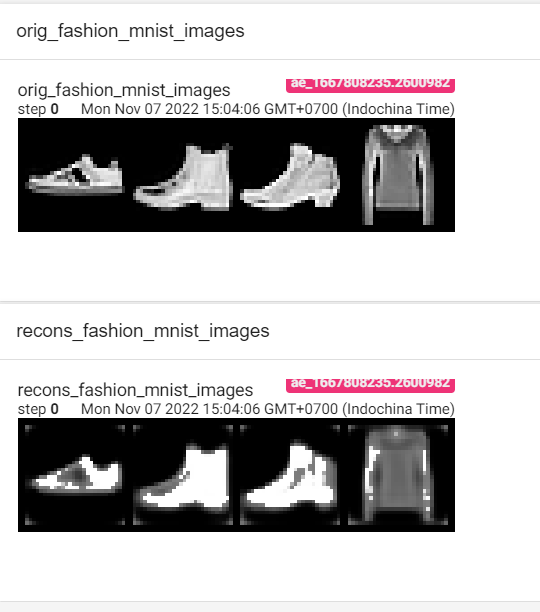

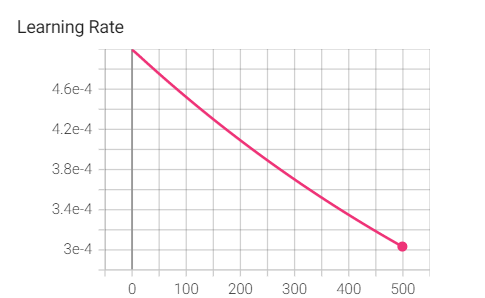

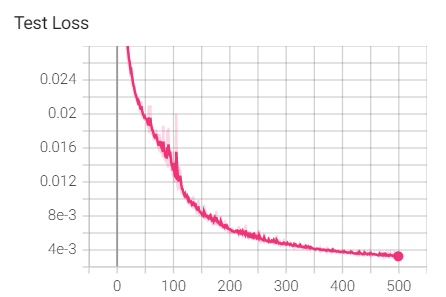

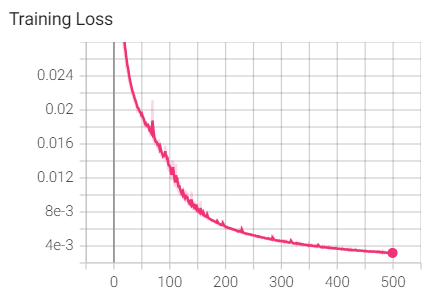

To access Tensorboard: tensorboard --logdir logs/ --port 8080